## Imports and routines

In [1]:
import sys
import os
import _init_paths
import importlib
import shutil
import numpy as np
import tqdm
import pickle
import torch
from utils.config import cfg
from pascalroidb import PascalRoiDB
from fastrcnnmodel import FastRCNNModel
from vgg import fast_rcnn_weights
from torch_utils import load_weights
from fastrcnntest import FastRCNNTest
from IPython.core.debugger import Tracer
%matplotlib inline

In [2]:
cfg.DATA_DIR = '../VOC/'
net_weights_file = 'intermediate/voc/weights-sgd-improved-40k.pth'
test_detections_file = 'detections-sgd-improved-40k.pkl'
year = '2007'
data_set_name = 'test'

## Load data

In [3]:
def load_data():
    devkit_path = os.path.join(cfg.DATA_DIR, 'VOCdevkit/')
    data_set = PascalRoiDB(devkit_path, data_set_name, year, 
                        shuffle_samples=False, mode='test')

    dataloader = torch.utils.data.DataLoader(
        data_set, batch_size=1, shuffle=False, num_workers=3)

    data_iter = dataloader.__iter__()
    return data_set, dataloader, data_iter


try:
    del data_set
    del dataloader
    del data_iter
except:
    pass

data_set, dataloader, data_iter = load_data()
model = None

Loaded from cache.


## Setup the network

In [4]:
try:
    del model
except NameError:
    pass

model = FastRCNNModel(dropout_p=0.5).cuda()
model.train(mode=False)
load_weights(model, net_weights_file)

## Tester

In [5]:
tester = FastRCNNTest(model, 
                      targets_mean=data_set.bbox_means, 
                      targets_std=data_set.bbox_stds, 
                      top_class_only=False,
                      class_detection_thresh=0.05, 
                      nms_thresh=0.3,
                      show_gt_boxes=True,
                      class_id_to_name=data_set.imdb._ind_to_class, 
                      data_loader=dataloader)

## Test a single image 

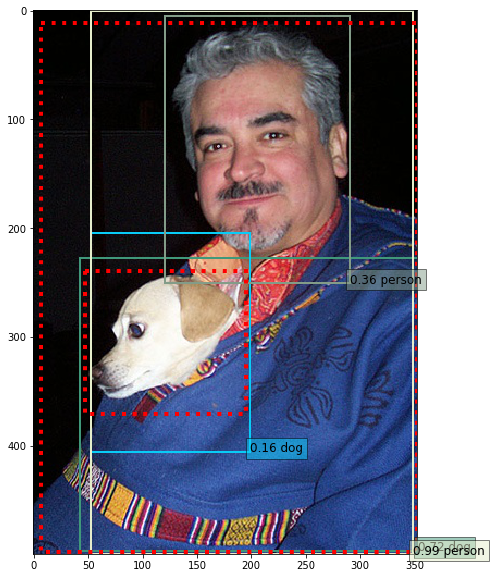

In [6]:
tester.reset_iterator()
_ = tester.test_next(display_detections=True)

##  Test all images

In [7]:
all_boxes = tester.test_all()

In [8]:
output_dir = 'intermediate/voc/'
det_file = os.path.join(output_dir, 'new-' + test_detections_file)
with open(det_file, 'wb') as f:
    pickle.dump(all_boxes, f, protocol=1)  # pickle.HIGHEST_PROTOCOL)

## Compare RBG and mine

In [32]:
output_dir = 'intermediate/voc/'
det_file = os.path.join(output_dir, test_detections_file)
with open(det_file, 'rb') as f:
    all_boxes = pickle.load(f)

In [19]:
output_dir = '../rbgirshick/py-faster-rcnn/output/default/voc_2007_test/vgg16_fast_rcnn_iter_40000/'
det_file = os.path.join(output_dir, 'detections.pkl')
with open(det_file, 'rb') as f:
    rbg_boxes = pickle.load(f, encoding='latin1')

In [8]:
sample_index = 0

In [ ]:
sample_index += 1
print('Mine')
tester.display_precomputed_boxes(sample_index, all_boxes)
print('RBG')
tester.display_precomputed_boxes(sample_index, rbg_boxes)
print('Done')

## Eval results

In [9]:
output_dir = 'output'
data_set.imdb.evaluate_detections(all_boxes, output_dir)

Writing aeroplane VOC results file
Writing bicycle VOC results file
Writing bird VOC results file
Writing boat VOC results file
Writing bottle VOC results file
Writing bus VOC results file
Writing car VOC results file
Writing cat VOC results file
Writing chair VOC results file
Writing cow VOC results file
Writing diningtable VOC results file
Writing dog VOC results file
Writing horse VOC results file
Writing motorbike VOC results file
Writing person VOC results file
Writing pottedplant VOC results file
Writing sheep VOC results file
Writing sofa VOC results file
Writing train VOC results file
Writing tvmonitor VOC results file
VOC07 metric? Yes
AP for aeroplane = 0.6423
AP for bicycle = 0.6974
AP for bird = 0.5596
AP for boat = 0.4486
AP for bottle = 0.2877
AP for bus = 0.6433
AP for car = 0.7135
AP for cat = 0.7383
AP for chair = 0.3709
AP for cow = 0.7067
AP for diningtable = 0.6181
AP for dog = 0.6827
AP for horse = 0.6590
AP for motorbike = 0.6925
AP for person = 0.5794
AP for pott

In [10]:
# cleanup
shutil.rmtree(output_dir)